# Comparison of Naive and User-based Recommender

## Imports

In [23]:
import utils as ut
import naive_recommender as rec1
import user_based_recommender as rec2
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import importlib

## Metrics definition

In [7]:
def genre_distribution(recommended_movies, movies, genre_matrix):
    """
    Evaluate the distribution of the genres of the recommended movies
    
    Args:
        recommended_movies (list): list of the recommended movies
        movies (DataFrame): DataFrame of the movies
        genre_matrix (DataFrame)

    Returns:
        dict: dictionary with the distribution of the genres
    """
    genre_counts = genre_matrix.loc[recommended_movies].sum()
    total = genre_counts.sum()
    if total > 0:
        return (genre_counts / total).to_dict()
    return {}

def compare_genre_distributions(dist1, dist2):
    """
    Compare of the two distribution of the genres, using the L1 distance
    
    """
    genres = set(dist1.keys()).union(set(dist2.keys()))
    return sum(abs(dist1.get(g, 0) - dist2.get(g, 0)) for g in genres)


## Dataset logic

In [10]:
# Load data and create genre matrix
path_to_ml_latest_small = 'ml-latest-small/'
dataset = ut.load_dataset_from_source(path_to_ml_latest_small)

# Generate the train and validation sets
ratings_train, ratings_val = ut.split_users(dataset["ratings.csv"], k=5)
movies = dataset["movies.csv"]
genre_matrix = ut.matrix_genres(movies)
movies_idx = movies["movieId"].values
users_idy = list(set(ratings_train["userId"].values))
matrix = rec2.generate_m(movies_idx, users_idy, ratings_train)

/home/iarena/Desktop/dtu/IRRS/lab/5/Irrs_lab5/utils.py:87: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for genre in genres: matrix.loc[idx_movie][genre] = 1


## Validation

In [21]:
# Selection of multiple test users
np.random.seed(42)
test_users = np.random.choice(ratings_val["userId"].unique(), size=15, replace=False)
k = 5  # Number of recommendations

results = []
for user_id in test_users:
    user_val_movies = ratings_val[ratings_val["userId"] == user_id]["movieId"].tolist()
    val_genre_dist = genre_distribution(user_val_movies, movies, genre_matrix)

    # Naive Recommender
    start_time = time.time()
    naive_recommendations = rec1.naive_recommender(ratings_train, movies, k)
    naive_time = time.time() - start_time
    naive_movie_ids = movies[movies["title"].isin(naive_recommendations)]["movieId"].tolist()
    naive_genre_dist = genre_distribution(naive_movie_ids, movies, genre_matrix)
    naive_dist = compare_genre_distributions(naive_genre_dist, val_genre_dist)

    # User-Based Recommender
    start_time = time.time()
    ubr_recommendations = rec2.user_based_recommender(user_id, matrix, movies_idx)
    ubr_time = time.time() - start_time
    ubr_movie_ids = [movie for movie, _ in ubr_recommendations[:k]]
    ubr_genre_dist = genre_distribution(ubr_movie_ids, movies, genre_matrix)
    ubr_dist = compare_genre_distributions(ubr_genre_dist, val_genre_dist)

    # Log results
    results.append({
        "userId": user_id,
        "Naive distance": round(naive_dist, 3),
        "User-based distance": round(ubr_dist, 3),
        "Naive time (ms)": round(naive_time*1000, 3),
        "User-based time (ms)": round(ubr_time*1000, 3)
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Summary statistics
naive_mean = results_df["Naive distance"].mean()
ubr_mean = results_df["User-based distance"].mean()
print(f"Average L1 Distance - Naive Recommender: {naive_mean:.4f}")
print(f"Average L1 Distance - User-Based Recommender: {ubr_mean:.4f}")

# Runtime comparison
naive_time_mean = results_df["Naive time (ms)"].mean()
ubr_time_mean = results_df["User-based time (ms)"].mean()
print(f"Average time - Naive Recommender: {naive_time_mean:.4f}")
print(f"Average time - User-Based Recommender: {ubr_time_mean:.4f}")

results_df


Average L1 Distance - Naive Recommender: 1.2293
Average L1 Distance - User-Based Recommender: 1.0788
Average time - Naive Recommender: 7.4876
Average time - User-Based Recommender: 33.3721


userId  Naive distance  User-based distance  Naive time (ms)  \
0       82           1.378                1.617            9.077   
1      219           1.600                1.029            7.895   
2       56           1.511                1.433            8.229   
3      599           0.978                0.733            7.089   
4      265           1.167                1.038            7.734   
5      156           1.111                1.033            7.582   
6      483           0.940                0.839            7.371   
7      322           1.111                0.778            7.302   
8      581           1.248                0.769            6.892   
9      292           1.286                1.321            7.042   
10     239           1.094                1.077            7.529   
11     251           1.278                0.417            7.367   
12     197           1.278                1.167            6.736   
13     395           1.190                1.371            7.499   
14     291           1.270                1.560            6.970   

    User-based time (ms)  
0                 29.932  
1                 45.110  
2                 20.654  
3                 96.287  
4                 25.251  
5                 34.816  
6                 50.064  
7                 24.326  
8                 19.862  
9                 38.278  
10                35.290  
11                20.845  
12                20.603  
13                21.002  
14                18.262

## Visualizations

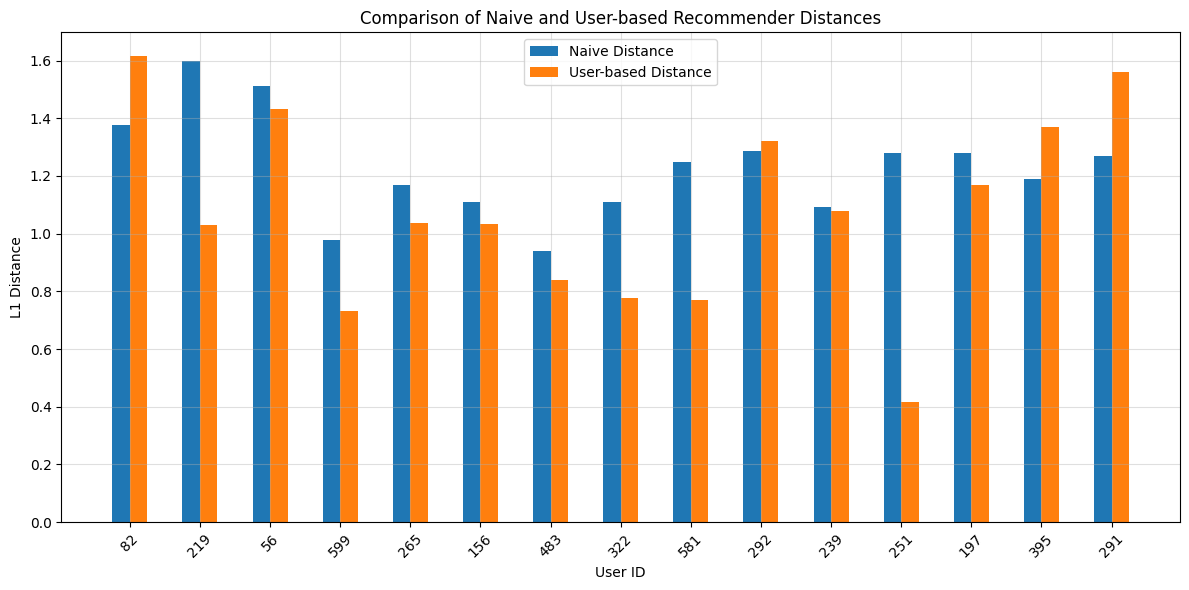

In [33]:
# Plotting the distances using a bar plot
plt.figure(figsize=(12, 6))
bar_width = 0.25
index = np.arange(len(results_df['userId']))

# Bar plots for Naive and User-based distances
bar1 = plt.bar(index, results_df['Naive distance'], bar_width, label='Naive Distance')
bar2 = plt.bar(index + bar_width, results_df['User-based distance'], bar_width, label='User-based Distance')

# Adding titles and labels
plt.title('Comparison of Naive and User-based Recommender Distances')
plt.xlabel('User ID')
plt.ylabel('L1 Distance')
plt.xticks(index + bar_width / 2, results_df['userId'], rotation=45)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


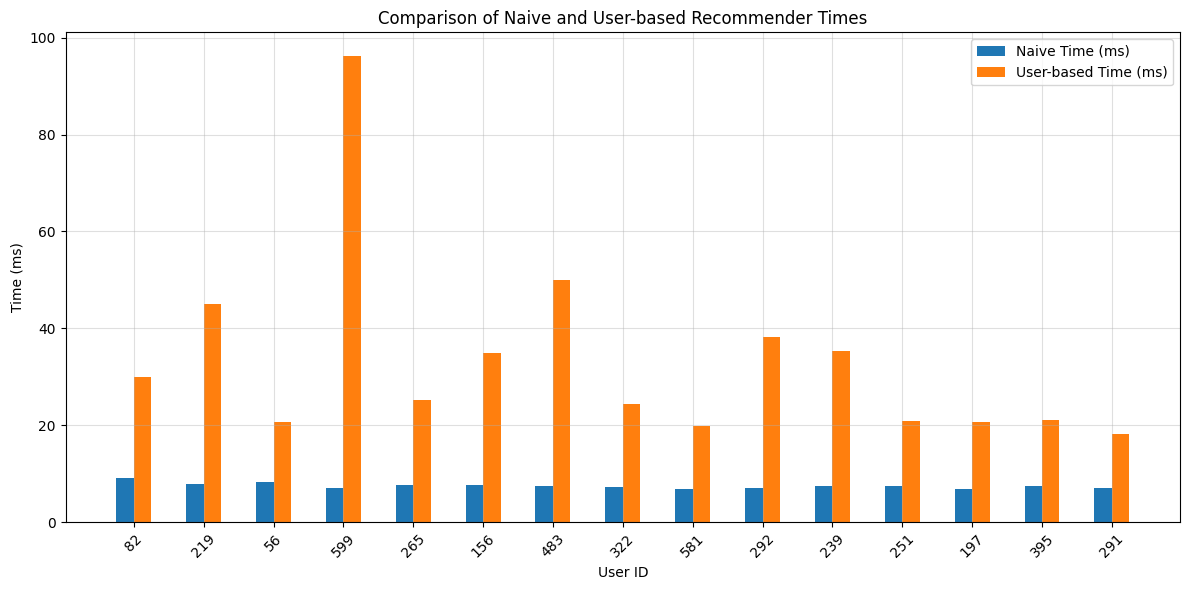

In [32]:
# Plotting the time differences using a bar plot
plt.figure(figsize=(12, 6))
bar_width = 0.25
index = np.arange(len(results_df['userId']))

# Bar plots for Naive and User-based times
bar1 = plt.bar(index, results_df['Naive time (ms)'], bar_width, label='Naive Time (ms)')
bar2 = plt.bar(index + bar_width, results_df['User-based time (ms)'], bar_width, label='User-based Time (ms)')

# Adding titles and labels
plt.title('Comparison of Naive and User-based Recommender Times')
plt.xlabel('User ID')
plt.ylabel('Time (ms)')
plt.xticks(index + bar_width / 2, results_df['userId'], rotation=45)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()